In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
graphviz_bin_path = '/opt/conda/envs/pymc-dev/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

In [3]:
az.style.use("arviz-darkgrid")

In [4]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

In [9]:
model1 = pm.Model()
with model1 as pooled:
    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


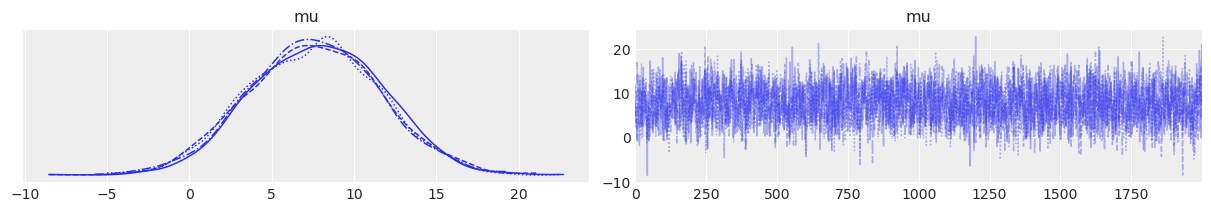

In [10]:
az.plot_trace(trace_p);

In [11]:
g = pm.model_to_graphviz(model1)

In [14]:
display(model1)

 mu ~ Normal(0, 1e+06)
obs ~ Normal(mu, <constant>)

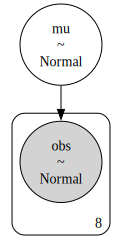

In [15]:
display(g)

In [16]:
model2 = pm.Model()

In [17]:
with model2 as hierarchical:
    eta = pm.Normal("eta", 0, 1, shape=J)
    # Hierarchical mean and SD
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

In [18]:
g2 = pm.model_to_graphviz(model2)

In [19]:
display(model2)

  eta ~ Normal(0, 1)
   mu ~ Normal(0, 10)
  tau ~ HalfNormal(0, 10)
theta ~ Deterministic(f(eta, mu, tau))
  obs ~ Normal(theta, <constant>)

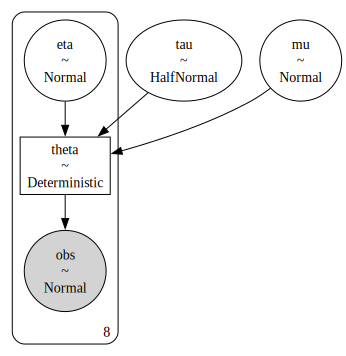

In [20]:
display(g2)

In [22]:
with model2 as hierarchical:
    trace_h = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


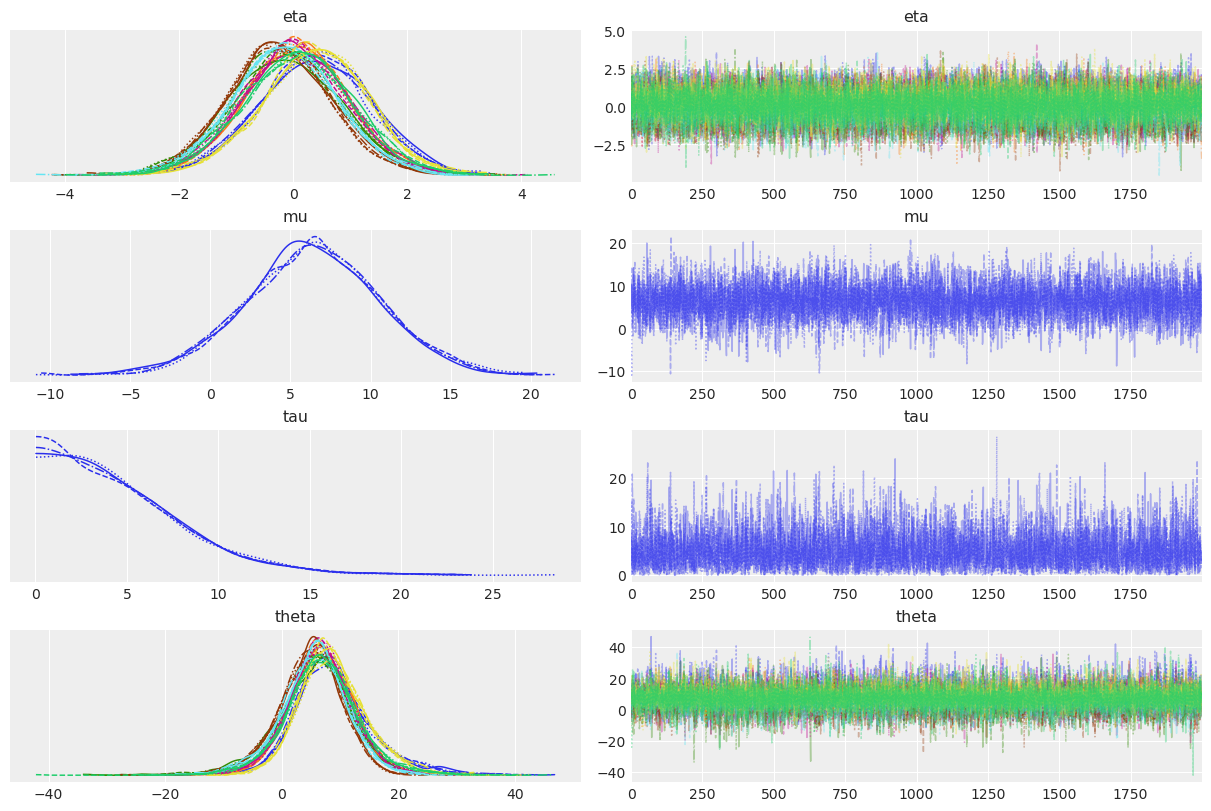

In [25]:
az.plot_trace(trace_h);

/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


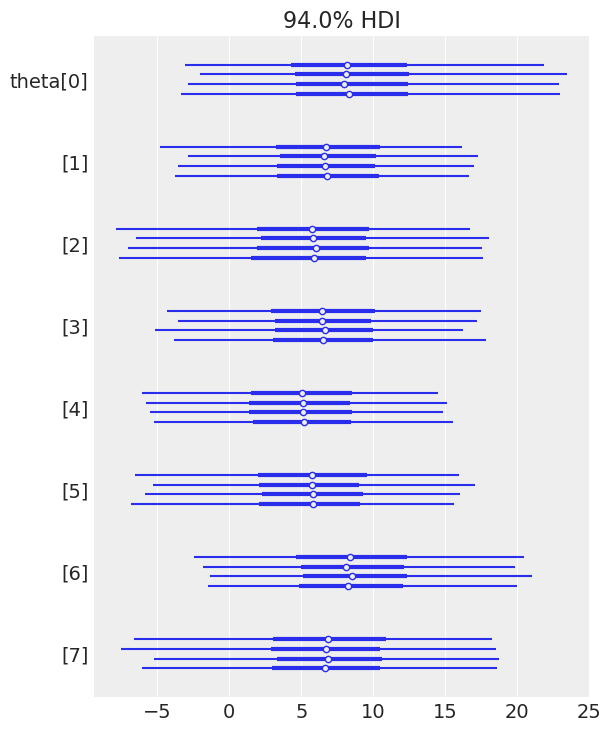

In [24]:
az.plot_forest(trace_h, var_names="theta");

In [26]:
with pooled:
    pm.compute_log_likelihood(trace_p)

In [27]:
pooled_loo = az.loo(trace_p)
pooled_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.52     1.11
p_loo        0.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [28]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)

In [29]:
hierarchical_loo = az.loo(trace_h)

hierarchical_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.79     1.08
p_loo        1.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3   37.5%
 (0.5, 0.7]   (ok)          5   62.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [30]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.518533,0.640698,0.000000,1.000000e+00,1.110306,0.00000,False,log
hierarchical,1,-30.792519,1.145937,0.273986,1.110223e-16,1.084861,0.22676,False,log


/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


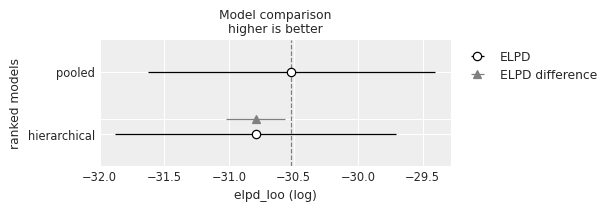

In [31]:
az.plot_compare(df_comp_loo, insample_dev=False);